# Greedy Learner - Step 2
Step 2: Optimization algorithm. Formally state the optimization problem where the objective function is the maximization of the cumulative expected margin over all the products. Design a greedy algorithm to optimize the objective function when all the parameters are known. The algorithm works as follows. At the beginning, every item is associated with the corresponding lowest price. Then, evaluate the marginal increase obtained when the price of a single product is increased by a single level, thus considering 5 potential different price configurations at every iteration, and choose the price configuration providing the best marginal increase (a price configuration specifies the price of every product). The algorithm stops when no new configuration among the 5 evaluated is better than the previous one. For instance, at the beginning, evaluate the 5 price configurations in which all the products are priced with the lowest price except for one product which is priced with the second lowest price. If all these price configurations are worse than the configuration in which all the products are priced with the lowest price, stop the algorithm and return the configuration with the lowest price for all the products. Otherwise, choose the best price configuration and re-iterate the algorithm. Notice that the algorithm monotonically increases the prices as well as the cumulative expected margin. Therefore, the algorithms cannot cycle. However, there is not guarantee that the algorithm will return the optimal price configuration. Develop the algorithm by Python.


### 1. Greedy Learner Structure

##### __init()__ 
This method initializes the learner parameters.

In [1]:
import numpy as np
'''
    - configuration_margin[]: margins of the five possible different derivation obtained from a starting configuration
    - t: counter variable
    - optimal_configuration[]: current optimal price configuration found
    - optimal_configuration_margin: margin of the current optimal configuration
    - isOptima: Flag used to signal whether the optimal configuration has been found by the learner
    - debug: flag used for debugging purpose
'''
def __init__(self, debug=False):
        self.configuration_margin = [0, 0, 0, 0, 0] 
        self.t = -1 
        self.optimal_configuration = [0, 0, 0, 0, 0]  
        self.optimal_configuration_margin = 0   
        self.isOptima = False
        self.debug = debug

##### __pull_arm()__
This method returns the new price configuration that has to be evaluated. It pulls a new arm of the optimal configuration and returns the new one.  
<br>starting configuration: [0, 0, 0, 0, 0]

<br>possible derivations:   
[1, 0, 0, 0, 0]                  
[0, 1, 0, 0, 0]                            
[0, 0, 1, 0, 0]                            
[0, 0, 0, 1, 0]                            
[0, 0, 0, 0, 1]

In [2]:
def pull_arm(self):
        if self.t == -1 or self.isOptima:
            return self.optimal_configuration

        try_configuration = self.optimal_configuration.copy()

        # Can't try arm above 3
        if try_configuration[self.t] < 3:
            try_configuration[self.t] += 1

        return try_configuration

##### __update(overallMargin)__ 
This procedure takes as input the `overallMargin` of the configuration that has been evaluated (by an evaluation method external to the learner class), and stores it `configuration_margin[]`. 
<br> When `self.t=5` all derivations have been tested and the procedure selects the most promising one by choosing the price configuration that provides the highest margin.
<br> If the new margin is higher that the current `optimal_configuration_margin` and `isOptima=False` (the optima hasn't been found yet), the learner updates `optimal_configuration_margin` with the new value and the `optimal_configuration[]` is updated with the new arm.

In [3]:
def update(self, overallMargin):
        # print(overallMargin)
        if self.t == -1:
            self.optimal_configuration_margin = overallMargin
            self.t += 1
            return

        # Set margin to 0 if the arm was not changed, so if the optimal configuration arm is already at 3
        # This is done to not compare again the optimal configuration with the other derivation, since if the arm is at
        # 3 it was not increased in the pull arm phase.
        if self.optimal_configuration[self.t] != 3:
            self.configuration_margin[self.t] = overallMargin
        else:
            self.configuration_margin[self.t] = 0

        self.t += 1

        # If t==5 we have tried all derivation and must update the optimal margin and configuration (if any are better)
        if self.t == 5:
            result = np.where(self.configuration_margin == np.amax(self.configuration_margin))
            result = result[0]
            result = np.random.choice(result)

            if np.amax(self.configuration_margin) > self.optimal_configuration_margin and not self.isOptima:
                if self.optimal_configuration[result] < 3:
                    self.optimal_configuration[result] += 1
                self.optimal_configuration_margin = np.amax(self.configuration_margin)
                if self.debug:
                    print(self.configuration_margin, self.optimal_configuration_margin, self.optimal_configuration)
            else:
                self.isOptima = True
                if self.debug:
                    print(self.configuration_margin, self.optimal_configuration_margin, self.optimal_configuration)
            self.t = 0

### 2. Greedy Learner behavior
1. The learner is initialized with the base-configuration in which all the products are priced with the lowest price: [0, 0, 0, 0, 0].
2. An _evaluation policy_ is employed in order to assign an __overall margin__ to the configuration. Different possible margin evaluation policies can be used to assign a margin to the configuration.
3. `update(overallMargin)` procedure of the learner is invoked
4. Method `pullArm()` of the learner sets the new configuration to be evaluated.
5. Repeat steps 2-3-4 untill an _exit condition_ is met

### 3. Greedy Learner sub-optimality
Although coputationally cheap the greedy approach is characterized by the major drawback of being extremely susceptible to <font color='lightgreen'>__local optimums__</font>. <br> The greedy approach is not guaranteed to return the __price configuration__ that is the <font color='lightgreen'>__global optima__</font>, indeed the learner may quickly find a single configuration that grants an immediate better margin than the other configurations belonging to the same level. By developing that configuration and by discarding the others, the learner might miss the opportunity to reach a final configuration with an overall better margin. This particular situation is further explained in the picture below:

![local_optima](greedy_learner_local_optima.PNG)

### Load different configurations
In order to provide a complete analysis of the behavior of the learner in different scenarios the learner is tested over a set of different configurations. <br>Each config.json file specifies all the problem's general parameters and defines each user's class specific parameters. Each config file includes:
- _margins_: 5x4 matrix that contains the product's margin for each possible price level. This is the only parameter that is valid for each user class
- _lambda_: coefficient that affects the probability of a secondary product in the second slot to be clicked on
- _alphas_: 1x5 list of alpha values (one per product). Each alpha represent the probability of a user to 'land' on a specific product page
- _conversionRates_: 5x4 matrix containing all the different conversion rates for that specific user class. Conversion rates vary depending on the price level and the product
- _clickProbability_: 5x4 matrix containing the probability of a user to click on a primary product when displayed with a specific price level
- _secondary_: a data structure that links each product with its secondary products
- _unitsShape_: 1x5 list of parameters of the random gamma distribution in charge of computing the number of units of product bought by each user
- _userMean_: parameter that specifies the average number of users of that specific class that visit the website
- _uservariance_: parameter that specifies the variance of the average number of users of that specific class that visit the website
- _features_: data structure that contains the feature of that class of users

In [4]:
import json
from Environment import Environment
import numpy as np
from Learner.BruteForce import *
from Model.UserClass import *
from Model.Product import *
from Model.GraphProbabilities import *
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline

configurationPathList = ['./Configs/config1.json', './Configs/config3.json', './Configs/configuration4.json']

def load_config(file_path):
    f = open(file_path)
    config = json.load(f)
    f.close()
    uc = config["classes"][0]

    productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]

    conversionRateLevels = uc["conversionRates"]
    marginsPerPrice = config["margins"]
    click_prob = uc["clickProbability"]
    lambda_p = uc["lambda"]
    alphas = uc["alphas"]
    units_mean = uc["unitsShape"]
    num_prices = len(conversionRateLevels[0])
    num_prods = len(alphas)
    usersMean = uc["usersMean"]
    usersVariance = uc["usersVariance"]

    optimal_arm = []

    pulledArm = [0, 3, 0, 2, 0] # [3, 2, 0, 3, 2] 
    margins = []
    convRates = []
    configuration = {"productList": productList, "conversionRateLevels": conversionRateLevels, "marginsPerPrice": marginsPerPrice, 
                    "click_prob": click_prob, "lambda_p": lambda_p, "alphas": alphas, "units_mean": units_mean, "num_prices": num_prices, 
                    "num_prods": num_prods, "optimal_arm": optimal_arm, "pulledArm": pulledArm, "margins": margins, "convRates": convRates,
                    "usersMean": usersMean, "usersVariance": usersVariance}
    return configuration

### Run simulation for each evaluation method
In order to answer to the following question: how the evaluation method impacts the solution search?

#### Evaluation method: Baseline evaluation
Baseline evaluation computes the __minimum__ margin that each price configuration is able to ensure, disregarding the probability of the user to click on the specific product.

In [5]:
from Model.Evaluator.Baseline import Baseline
from Learner.GreedyLearner import *

baselineResults = []
for c_path in configurationPathList:
    config = load_config(c_path)
    greedyLearner = GreedyLearner(debug=True)
 
    pulledArm = greedyLearner.pull_arm()
    previousConfig = []
    while pulledArm != previousConfig:
        print("pulledArm: ", pulledArm)
        armMargins = []
        armConvRates = []
        for k in range(0, len(pulledArm)):
            armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
            armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
        # Initialization of Baseline evaluator object:
        baselineEval = Baseline(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
                    alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
        # Price configuration evaluation and greedy Learner margin update:
        margin = baselineEval.computeMargin()
        greedyLearner.update(margin)
 
        previousConfig = pulledArm
        pulledArm = greedyLearner.pull_arm()
    
    baselineResults.append([greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin])

for i in range (0, len(baselineResults)):
    print("config_file {}: otpimal_configuration = {}, Margin = {}".format((i+1), baselineResults[i][0], baselineResults[i][1]))

pulledArm:  [0, 0, 0, 0, 0]
pulledArm:  [1, 0, 0, 0, 0]
pulledArm:  [0, 1, 0, 0, 0]
pulledArm:  [0, 0, 1, 0, 0]
pulledArm:  [0, 0, 0, 1, 0]
pulledArm:  [0, 0, 0, 0, 1]
[7.4907, 9.5207, 7.2612, 8.3412, 7.234500000000001] 9.5207 [0, 1, 0, 0, 0]
pulledArm:  [1, 1, 0, 0, 0]
pulledArm:  [0, 2, 0, 0, 0]
pulledArm:  [0, 1, 1, 0, 0]
pulledArm:  [0, 1, 0, 1, 0]
pulledArm:  [0, 1, 0, 0, 1]
[9.6782, 11.083200000000001, 9.448699999999999, 10.5287, 9.421999999999999] 11.083200000000001 [0, 2, 0, 0, 0]
pulledArm:  [1, 2, 0, 0, 0]
pulledArm:  [0, 3, 0, 0, 0]
pulledArm:  [0, 2, 1, 0, 0]
pulledArm:  [0, 2, 0, 1, 0]
pulledArm:  [0, 2, 0, 0, 1]
[11.2407, 7.020700000000001, 11.011199999999999, 12.0912, 10.9845] 12.0912 [0, 2, 0, 1, 0]
pulledArm:  [1, 2, 0, 1, 0]
pulledArm:  [0, 3, 0, 1, 0]
pulledArm:  [0, 2, 1, 1, 0]
pulledArm:  [0, 2, 0, 2, 0]
pulledArm:  [0, 2, 0, 1, 1]
[12.2487, 8.0287, 12.019199999999998, 12.217200000000002, 11.9925] 12.2487 [1, 2, 0, 1, 0]
pulledArm:  [2, 2, 0, 1, 0]
pulledArm:  [1, 

#### Evaluation method: Graph evaluation
The graph evaluation exploits the assumption of _perfect observability_ of each user actions. The method consists in evaluating each configuration by computing the <font color='lightgreen'>__overall expected value__</font> of a given configuration. <br>The <font color='lightgreen'>__overall expected value__</font> is computed as:

$\mathbb{E}[c] = \sum\limits _{i \in P}\alpha_{i} \mathbb{E}[i, c_i]$         

<br>where $\alpha = \{\alpha_1, \alpha_2, \alpha_3, \alpha_4, \alpha_5\}$ is the list of alphas and $P = \{1, 2, 3, 4, 5\}$ is the list of products.
<br><font color='pink'>$\mathbb{E}[i, c_i]$</font> is the <font color='pink'>__expected margin of product i__</font> given <font color='lightgreen'>__configuration c__</font> which is computed using the products graph

![product_graph](graph1.png)

<br> Suppose $\alpha_1 = 1$, which is equivalent to say $\alpha = \{1, 0, 0, 0, 0\}$, Probability $w[i]$ is the probability to click on product $i$ when $i$ is displayed in the first slot, while <font color='lightgreen'>$w[i]\lambda$</font> is the probability of clicking on the same product $i$ when it is displayed in the second slot.

$\mathbb{E}[i, c] =$ <font color='lightblue'>$P(p_i)$</font> $\cdot $ <font color='yellow'>$M[i][$ <font color='lightgreen'>$c_i$</font> $]$</font> $\cdot$ <font color='orange'>$CR[i][$ <font color='lightgreen'>$c_i$</font> $]$</font>

- <font color='lightgreen'>$c_i$</font> is the price level of product $i$ considering configuration $c$, namely `c[i]`
- <font color='lightblue'>$P(p_i)$</font> is the probability that product $i$ has to be clicked on.
- <font color='yellow'>$M[i][$ <font color='lightgreen'>$c_i$</font> $]$</font> is the _margin_ that the e-commerce gains from product $i$ when it's sold at price level $c_i$
- <font color='orange'>$CR[i][$ <font color='lightgreen'>$c_i$</font> $]$</font> is the conversion rate of the customer for product $i$ when sold at price configuration $c_i$

To compute probability <font color='lightblue'>$P(p_i)$</font>, we exploit the fact that the products' interconnections are fixed, considering the connections depicted above we can expand the connection graph and obtain a __reachability tree__, when starting from a node we obtain all paths leading to the others:

![reachability_tree](reachability_tree.png)

The probability of visiting a node $p_i$ of the tree (<font color='lightblue'>$P(p_i)$</font>) is given by the probabilities of reaching that node in each __feasible__ path of the tree that contains $p_i$. That would be <font color='lightblue'>$P(p_i)$</font> $= P(path_1) \lor P(path_2) \lor ... \lor P(path_n)$

<br><font color='pink'>__NB:__</font> Each path has a maximum length of 5 since each product cannot be displayed as primary twice.

Consider for instance node <font color='lightgreen'>D</font>, the feasible plath leading to it are: 
1. A -> B -> <font color='lightgreen'>D</font>
2. A -> B -> E -> <font color='lightgreen'>D</font>
3. A -> B -> E -> C -> <font color='lightgreen'>D</font>
4. A -> C -> B -> <font color='lightgreen'>D</font>
5. A -> C -> <font color='lightgreen'>D</font>

![reachability_tree_node_D](reachability_tree_node_D.png)

So the overall probability of visiting node <font color='lightgreen'>D</font> is:

$\mathbb{E}[c] = 1 - \prod\limits _{k = 0} ^{\#Paths(i)}[1- P(Path_i)]$

Probability $P(Path_i)$ is simply the product of each conditional probability of visiting node N from N', $P(N|N')$

In conclusion we've obtained:

$\mathbb{E}[c] = \sum\limits _{i \in P}\{ \alpha_{i} \cdot M[i][c_i] \cdot CR[i][c_i] \cdot \{1 - \prod\limits _{k = 0} ^{\#Paths(i)}[1- P(Path_i)]\}\}$

In [6]:
from Learner.GreedyLearner import *


graphEvalResults = []
for c_path in configurationPathList:
    config = load_config(c_path)
    greedyLearner = GreedyLearner(debug=True)
 
    pulledArm = greedyLearner.pull_arm()
    previousConfig = []
    while pulledArm != previousConfig:
        armMargins = []
        armConvRates = []
        for k in range(0, len(pulledArm)):
            armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
            armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
        # Initialization of GraphEvaluator object:
        graphEval = GraphEvaluator(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
                    alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
        # Price configuration evaluation and greedy Learner margin update:
        margin = graphEval.computeMargin()
   
        greedyLearner.update(margin)
 
        previousConfig = pulledArm
        pulledArm = greedyLearner.pull_arm()
    
    graphEvalResults.append([greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin])

for i in range (0, len(graphEvalResults)):
    print("config_file {}: otpimal_configuration = {}, Margin = {}".format((i+1), graphEvalResults[i][0], graphEvalResults[i][1]))

[33.6, 39.65, 32.6, 38.85, 32.35] 39.65 [0, 1, 0, 0, 0]
[40.2, 44.300000000000004, 39.349999999999994, 45.300000000000004, 38.8] 45.300000000000004 [0, 1, 0, 1, 0]
[45.6, 50.099999999999994, 45.050000000000004, 46.0, 44.75] 50.099999999999994 [0, 2, 0, 1, 0]
[50.39999999999999, 37.800000000000004, 49.55, 50.65, 49.4] 50.65 [0, 2, 0, 2, 0]
[50.949999999999996, 38.5, 50.4, 51.099999999999994, 50.24999999999999] 51.099999999999994 [0, 2, 0, 3, 0]
[51.64999999999999, 39.1, 50.949999999999996, 0, 50.8] 51.64999999999999 [1, 2, 0, 3, 0]
[53.050000000000004, 39.65, 51.24999999999999, 0, 50.8] 53.050000000000004 [2, 2, 0, 3, 0]
[52.49999999999999, 40.900000000000006, 52.65, 0, 52.199999999999996] 53.050000000000004 [2, 2, 0, 3, 0]
[27.5, 31.200000000000003, 38.28, 38.93000000000001, 35.550000000000004] 38.93000000000001 [0, 0, 0, 1, 0]
[45.89, 49.13, 56.21, 21.0, 53.48000000000001] 56.21 [0, 0, 1, 1, 0]
[63.17, 66.94, 40.82000000000001, 38.68, 71.28999999999999] 71.28999999999999 [0, 0, 1, 1, 

#### Evaluation method: Environment simulation 

In [18]:
import matplotlib.pyplot as plt
from Learner.GreedyLearner import *

def totalMarginPerExperiment(envReturn, roundUsers, marginsPerPrice, pulledArm):
    #print("Experiment recap: #Episodes: {}, #Users: {}, Pulled Arm: {}".format(len(envReturn), roundUsers, pulledArm))
    TotMargin = 0
    for e in envReturn:
       if e.bought:
            #print("Experiment recap: Product: {}, Margin of single unit: {}, #Units sold: {}".format(e.product, marginsPerPrice[e.product][pulledArm[e.product]], e.units))
            TotMargin += marginsPerPrice[e.product][pulledArm[e.product]] * e.units
    #print("Total margin of Experiment: {}, average margin per user: {}".format(TotMargin, (TotMargin/roundUsers)))
    return TotMargin / roundUsers
 


envEvalResults = []
for c_path in configurationPathList:
    print("\nTrying configuration -> ", c_path)
    config = load_config(c_path)
    environment = Environment(config_path=c_path)
    greedyLearner = GreedyLearner(debug=True)
 
    pulledArm = greedyLearner.pull_arm()
    #pulledArm = [2, 2, 0, 3, 0]
    environment.setPriceLevels(pulledArm)
    environmentRoundResult = environment.round()

    n_experiment = 50

    previousConfig = []
    allMargins = []
    #while pulledArm != previousConfig:
    while pulledArm != previousConfig:
        cumulativeConfigurationMargin = 0
        for k in range(0, n_experiment):
            cumulativeConfigurationMargin += totalMarginPerExperiment(environmentRoundResult["episodes"], environmentRoundResult["roundUsers"], config["marginsPerPrice"], pulledArm)
            environmentRoundResult = environment.round()
 
        average_configuration_margin = ((cumulativeConfigurationMargin / n_experiment))

        allMargins.append(average_configuration_margin)
        greedyLearner.update(average_configuration_margin)
    
        previousConfig = pulledArm
        pulledArm = greedyLearner.pull_arm()

    envEvalResults.append([greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin])

for i in range (0, len(envEvalResults)):
    print("config_file {}: otpimal_configuration = {}, Margin = {}".format((i+1), envEvalResults[i][0], envEvalResults[i][1]))

'''
print("Optima", greedyLearner.optimal_configuration)
print("Optima margin", greedyLearner.optimal_configuration_margin)
print("allMargins", allMargins)


fig, ax = plt.subplots()
ax.plot(allMargins)
plt.show()
'''
   



Trying configuration ->  ./Configs/config1.json
[12.033215929656928, 14.089765411076007, 11.969944865817247, 12.803758547619468, 11.612196196969085] 14.089765411076007 [0, 1, 0, 0, 0]
[15.088306119087301, 17.467938964096295, 13.523613084213578, 14.975950459671893, 15.826187298700187] 17.467938964096295 [0, 2, 0, 0, 0]
[16.063947233295576, 15.014924985439718, 16.115659409241896, 17.450087221519826, 16.025789611979064] 17.467938964096295 [0, 2, 0, 0, 0]

Trying configuration ->  ./Configs/config3.json
[14.65100469584521, 15.299895220962599, 16.654485263796825, 13.490540080531233, 12.729899750795735] 16.654485263796825 [0, 0, 1, 0, 0]
[22.66411245748372, 20.88869134856571, 15.068714513910615, 19.617729019388197, 20.348102692230054] 22.66411245748372 [1, 0, 1, 0, 0]
[21.325853202424604, 28.519750687156606, 22.075625031678168, 27.034956750718592, 24.610140805332488] 28.519750687156606 [1, 1, 1, 0, 0]
[28.050497563065793, 28.704667831869394, 27.842234892253718, 32.7120651013467, 32.54091863

'\nprint("Optima", greedyLearner.optimal_configuration)\nprint("Optima margin", greedyLearner.optimal_configuration_margin)\nprint("allMargins", allMargins)\n\n\nfig, ax = plt.subplots()\nax.plot(allMargins)\nplt.show()\n'

#### Results

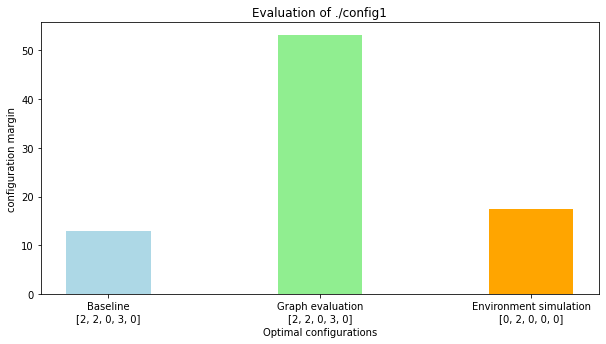

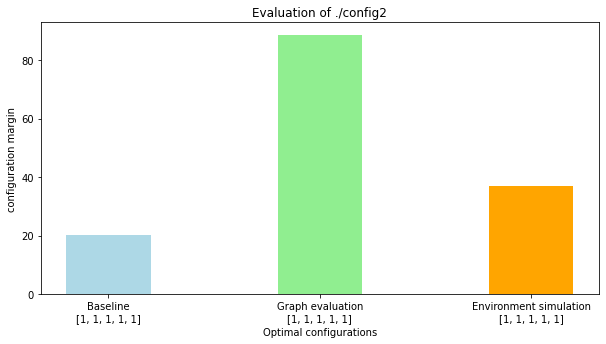

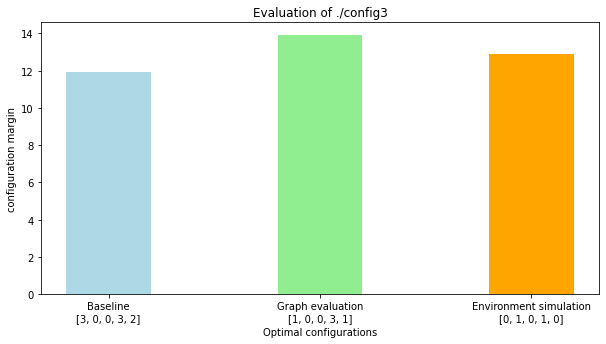

In [19]:
bar_colors = ['lightblue', 'lightgreen', 'orange']
for i in range (0, len(configurationPathList)):
        evaluation_methods = ["Baseline\n{}".format(baselineResults[i][0]), "Graph evaluation\n{}".format(graphEvalResults[i][0]), "Environment simulation\n{}".format(envEvalResults[i][0])]
        margins = [baselineResults[i][1], graphEvalResults[i][1], envEvalResults[i][1]]
  
        fig = plt.figure(figsize = (10, 5))
 
        # creating the bar plot
        plt.bar(evaluation_methods, margins, color =bar_colors,
                width = 0.4)
 
        plt.xlabel("Optimal configurations")
        plt.ylabel("configuration margin")
        plt.title("Evaluation of ./config{}".format(i+1))
        plt.show()




### Run simulation with specific evaluation but different learner (BruteForce vs GreedyLearner)
In order to answer to the question, is the solution found by the Greedy the optimal one?

In [20]:
# Fix the evaluator as GraphEvaluator and check how the optimal reward differ in the two classes

results = []
for c_path in configurationPathList:
    config = load_config(c_path)
    greedyLearner = GreedyLearner(debug=True)
    bruteForce = BruteForce()

    ##### Greedy learner: #####
    greedy_margins_to_plot = []
    greedy_arms_to_plot = []
    pulledArm = greedyLearner.pull_arm()
    previousConfig = []
    greedyIteration = 0
    while pulledArm != previousConfig:
        greedyIteration += 1
        print("pulledArm: ", pulledArm)
        armMargins = []
        armConvRates = []
        for k in range(0, len(pulledArm)):
            armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
            armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
        # Initialization of GraphEvaluator object:
        graphEval = GraphEvaluator(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
                    alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
        # Price configuration evaluation and greedy Learner margin update:
        margin = graphEval.computeMargin()
        greedyLearner.update(margin)
    
        greedy_margins_to_plot.append(margin)
        greedy_arms_to_plot.append("{}".format(pulledArm))

        previousConfig = pulledArm
        pulledArm = greedyLearner.pull_arm()


    ##### Brute force: #####

    bruteForce_margins_to_plot = []
    bruteForce_arms_to_plot = []

    bruteForceIteration = 0
    num_prices = len(config['conversionRateLevels'][0])
    num_prods = len(config['alphas'])
    for i in range(0, num_prices**num_prods):
        bruteForceIteration += 1
        pulledArm = bruteForce.pull_arm()
        #print("pulledArm: ", pulledArm)
        armMargins = []
        armConvRates = []
        for k in range(0, len(pulledArm)):
            armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
            armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
        # Initialization of GraphEvaluator object:
        graphEval = GraphEvaluator(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
                 alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
        # Price configuration evaluation and greedy Learner margin update:
        margin = graphEval.computeMargin()
        #print("Margin: ", margin)
        bruteForce.update(margin)

        bruteForce_margins_to_plot.append(margin)
        bruteForce_arms_to_plot.append("{}".format(pulledArm))

    greedy_results = [greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin]
    bruteForce_results = [bruteForce.optimal_configuration, bruteForce.optimal_configuration_margin]
    config_results = {
        "greedy_results": greedy_results,
        "bruteForce_results": bruteForce_results,
        "greedy_arms_to_plot": greedy_margins_to_plot,
        "greedy_iterations": greedyIteration,
        "greedy_margins_to_plot": greedy_margins_to_plot,
        "bruteForce_arms_to_plot": bruteForce_arms_to_plot,
        "bruteForce_margins_to_plot": bruteForce_margins_to_plot,
        "bruteForce_iterations": bruteForceIteration
    }
    results.append(config_results)
    #print("\n##### RESULTS OF {} #####".format(c_path))
    #print("Greedy learner Optima:{} margin = {} ".format(greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin))
    #print("Bruteforce Optima:{} margin = {} ".format(bruteForce.optimal_configuration, bruteForce.optimal_configuration_margin))

for i in range(0, len(configurationPathList)):
    print("\n##### RESULTS OF config{} #####".format(i+1))
    print("Greedy learner Optima:{} margin = {} ".format(results[i]["greedy_results"][0], results[i]["greedy_results"][1]))
    print("Bruteforce Optima:{} margin = {} ".format(results[i]["bruteForce_results"][0], results[i]["bruteForce_results"][1]))



pulledArm:  [0, 0, 0, 0, 0]
pulledArm:  [1, 0, 0, 0, 0]
pulledArm:  [0, 1, 0, 0, 0]
pulledArm:  [0, 0, 1, 0, 0]
pulledArm:  [0, 0, 0, 1, 0]
pulledArm:  [0, 0, 0, 0, 1]
[33.6, 39.65, 32.6, 38.85, 32.35] 39.65 [0, 1, 0, 0, 0]
pulledArm:  [1, 1, 0, 0, 0]
pulledArm:  [0, 2, 0, 0, 0]
pulledArm:  [0, 1, 1, 0, 0]
pulledArm:  [0, 1, 0, 1, 0]
pulledArm:  [0, 1, 0, 0, 1]
[40.2, 44.300000000000004, 39.349999999999994, 45.300000000000004, 38.8] 45.300000000000004 [0, 1, 0, 1, 0]
pulledArm:  [1, 1, 0, 1, 0]
pulledArm:  [0, 2, 0, 1, 0]
pulledArm:  [0, 1, 1, 1, 0]
pulledArm:  [0, 1, 0, 2, 0]
pulledArm:  [0, 1, 0, 1, 1]
[45.6, 50.099999999999994, 45.050000000000004, 46.0, 44.75] 50.099999999999994 [0, 2, 0, 1, 0]
pulledArm:  [1, 2, 0, 1, 0]
pulledArm:  [0, 3, 0, 1, 0]
pulledArm:  [0, 2, 1, 1, 0]
pulledArm:  [0, 2, 0, 2, 0]
pulledArm:  [0, 2, 0, 1, 1]
[50.39999999999999, 37.800000000000004, 49.55, 50.65, 49.4] 50.65 [0, 2, 0, 2, 0]
pulledArm:  [1, 2, 0, 2, 0]
pulledArm:  [0, 3, 0, 2, 0]
pulledArm:  [0,

In [10]:
# To evaluate a single specific price configuration
config = load_config('./Configs/config1.json')
pulledArm = [2, 2, 0, 2, 2]

armMargins = []
armConvRates = []
for k in range(0, len(pulledArm)):
    armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
    armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
# Initialization of GraphEvaluator object:
graphEval = GraphEvaluator(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
            alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
# Price configuration evaluation and greedy Learner margin update:
margin = graphEval.computeMargin()
greedyLearner.update(margin)

print("pulled arm: ", pulledArm)
print("margin: ", margin)

pulled arm:  [2, 2, 0, 2, 2]
margin:  53.050000000000004


#### Plot the results

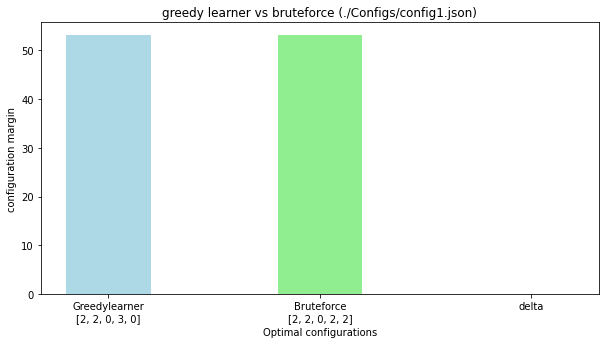

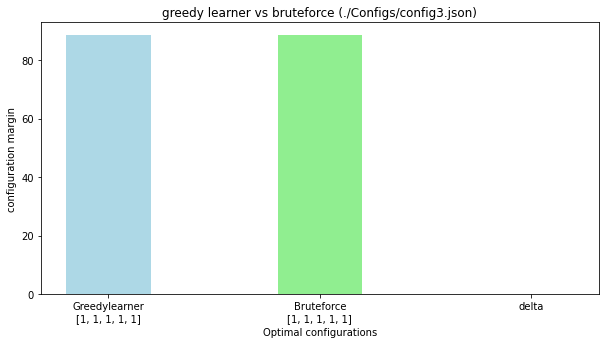

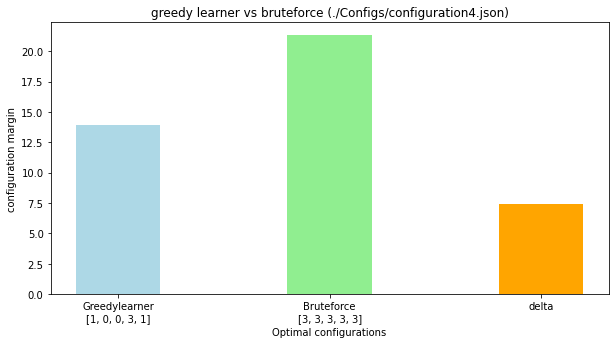

In [21]:
optima_configurations = ["Greedylearner\n{}".format(greedyLearner.optimal_configuration), "Bruteforce\n{}".format(bruteForce.optimal_configuration)]
configuration_margins = [greedyLearner.optimal_configuration_margin, bruteForce.optimal_configuration_margin]

for i in range (0, len(configurationPathList)):
    c_path = configurationPathList[i]
    fig = plt.figure(figsize = (10, 5))
    
    '''
    greedy_configuration = results[i]["greedy_results"][0]
    greedy_margin = results[i]["greedy_results"][1]

    bruteForce_configuration = results[i]["bruteForce_results"][0]
    bruteForce_margin = results[i]["bruteForce_results"][1]
    '''

    optima_configurations = ["Greedylearner\n{}".format(results[i]["greedy_results"][0]), "Bruteforce\n{}".format(results[i]["bruteForce_results"][0]), "delta"]
    configuration_margins = [results[i]["greedy_results"][1], results[i]["bruteForce_results"][1], (results[i]["bruteForce_results"][1]-results[i]["greedy_results"][1])]

    # creating the bar plot
    plt.bar(optima_configurations, configuration_margins, color = bar_colors, width = 0.4)
 
    plt.xlabel("Optimal configurations")
    plt.ylabel("configuration margin")
    plt.title("greedy learner vs bruteforce ({})".format(c_path))
    plt.show()
